In [1]:
import os
import re
import numpy as np
import simpy
import time
import math
from numpy import random
import matplotlib.pyplot as plt
from scipy.stats import poisson

In [2]:
"""
Pure image capture Satellite with FOFS scheduling policy simulator.

Covers:

- Arrival pattern of image requests are Poisson distributed arrival date
- Rate service depends on number of queded reqeusts.

"""

import simpy


RANDOM_SEED = 420
REQ_ARRIVAL_MU = 10
PROC_BASE_MU = 0.8
N_REQUESTS = 100000

"""
The Satellite is the entity that will process the requests. It emulates a waiting time depending on how many items
it has in its waiting queue.
"""

class Satellite(object):
    """
    The Satellite handles each request with an exponential wait that depends on the number of Queued items.
    """
    
    def __init__(self, env):
        self.env = env
        self.machine = simpy.Resource(env)
        self.elements_in_queue = []
        self.closed = False
        
    def process_req(self):
        q_size = len(self.machine.queue)

        
        self.elements_in_queue.append(q_size)
        req_procesing_time = random.exponential(1 / (PROC_BASE_MU * (q_size + 1) ))
        yield self.env.timeout(req_procesing_time)
    
    def get_internal_sample(self):
        return self.elements_in_queue
        
    def close(self):
        self.closed = True
    

def image_request(env, cw, processing_times):
    """Each image equest arrives at the satellite. And waits to be processed."""


    req_incom = env.now
    with cw.machine.request() as request:
        yield request


        yield env.process(cw.process_req())
        
        processing_times.append(env.now - req_incom)



def request_generator(env, satellite, processing_times):
    """ Request generator following a Poisson distribution with Lambda = REQ_ARRIVAL_MU"""

    
    i = 0

    # Create more cars while the simulation is running
    while i < N_REQUESTS:
        req_arrival_time = random.exponential(1 / REQ_ARRIVAL_MU)
        yield env.timeout(req_arrival_time)
        i += 1
        env.process(image_request(env, satellite, processing_times))
    
    satellite.close()

"""
 Timed sampling function of elements in the internal queue.
""" 
def get_values(env, satellite, queue_size):
    while not satellite.closed:
        yield env.timeout(0.01)
        queue_size.append(len(satellite.machine.queue))






In [3]:
RANDOM_SEED = 420
REQ_ARRIVAL_MU = 10
PROC_BASE_MU = 0.8
N_REQUESTS = 100000

random.seed(RANDOM_SEED)

# Create an environment and start the setup process
env = simpy.Environment()
satellite = Satellite(env)

processing_times = []
external_sampling = []
env.process(get_values(env, satellite, external_sampling))

env.process(request_generator(env, satellite, processing_times))

# Execute!
env.run()

Text(0, 0.5, 'Probability')

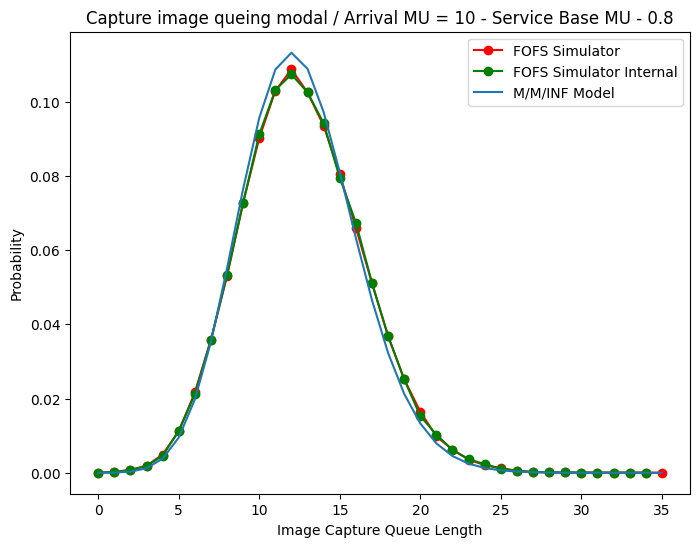

In [4]:
#####

# Modelo realizado para un MU de llegada de 10 req por dia y un MU de procesamiento de 0.8 req por día


#####


def rel_freq(x):
    vals = set(x)
    y = [x.count(value)/len(x) for value in set(x)] 
    x_vals = [value for value in set(x)]
    return y, x_vals

## External sampling mapping to x, y
y, x = rel_freq(external_sampling)

## Internal sampling mapping to x, y
y_internal, x_internal = rel_freq(satellite.get_internal_sample())

# poisson distribution data for y-axis
x_po = np.arange(0, len(x), 1)
y_po = poisson.pmf(x, mu=REQ_ARRIVAL_MU/PROC_BASE_MU)
 
 
# plotting the graph

plt.show()

fig, ax = plt.subplots(figsize=(8,6))
# ax.figure(figsize=(10,8))
ax.plot(x, y, 'r-o', label='FOFS Simulator')
ax.plot(x_internal, y_internal, 'g-o', label='FOFS Simulator Internal')

ax.set_title('Capture image queing modal / Arrival MU = 10 - Service Base MU - 0.8')

ax.plot(x_po, y_po, label='M/M/INF Model')
ax.legend()

ax.set_xlabel('Image Capture Queue Length')
ax.set_ylabel('Probability')

### Tamaño promedio de la cola 

$$  Li = \frac{\lambda}{\mu} $$

In [6]:
val = REQ_ARRIVAL_MU/PROC_BASE_MU
print('Tamaño de la muestra %d' % N_REQUESTS)

print('Resultado esperado %f' % val)
print('Resultado obtenido %f' % np.average(external_sampling))


Tamaño de la muestra 100000
Resultado esperado 12.500000
Resultado obtenido 12.657853


### Tiempo promedio de espera

$$  W = \frac{Li}{\lambda} $$

In [7]:
val = REQ_ARRIVAL_MU/PROC_BASE_MU
print('Tamaño de la muestra %d' % N_REQUESTS)

print('Resultado esperado %f' % (1 / PROC_BASE_MU))
print('Resultado obtenido %f' % np.average(processing_times))


Tamaño de la muestra 100000
Resultado esperado 1.250000
Resultado obtenido 1.362575


Text(0, 0.5, 'Probability')

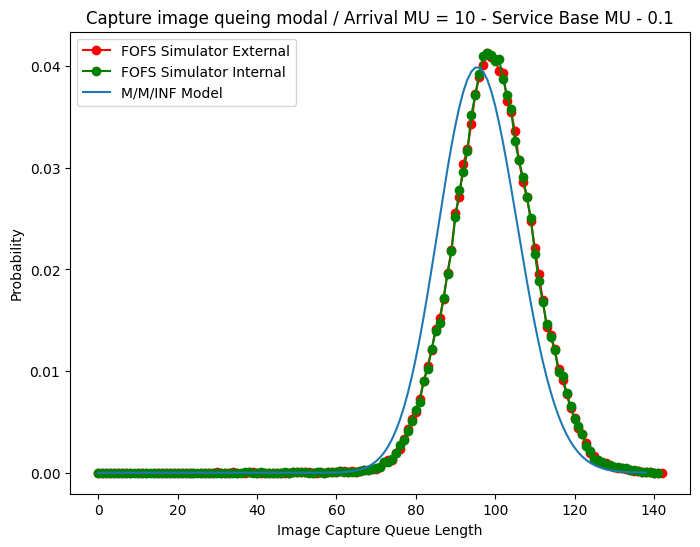

In [8]:
#####

# Modelo realizado para un MU de llegada de 10 req por dia y un MU de procesamiento de 0.1 req por día


#####


RANDOM_SEED = 420
REQ_ARRIVAL_MU = 10
PROC_BASE_MU = 0.1
N_REQUESTS = 100000

random.seed(RANDOM_SEED)

# Create an environment and start the setup process
env = simpy.Environment()
satellite = Satellite(env)

processing_times = []
external_sampling = []
env.process(get_values(env, satellite, external_sampling))

env.process(request_generator(env, satellite, processing_times))

# Execute!
env.run()


## External sampling mapping to x, y
y, x = rel_freq(external_sampling)

## Internal sampling mapping to x, y
y_internal, x_internal = rel_freq(satellite.get_internal_sample())

# poisson distribution data for y-axis
x_po = np.arange(0, len(x), 1)
y_po = poisson.pmf(x, mu=REQ_ARRIVAL_MU/PROC_BASE_MU)
 
 
# plotting the graph

plt.show()

fig, ax = plt.subplots(figsize=(8,6))
# ax.figure(figsize=(10,8))
ax.plot(x, y, 'r-o', label='FOFS Simulator External')
ax.plot(x_internal, y_internal, 'g-o', label='FOFS Simulator Internal')

ax.set_title('Capture image queing modal / Arrival MU = 10 - Service Base MU - 0.1')
ax.plot(x_po, y_po, label='M/M/INF Model')
ax.legend()

ax.set_xlabel('Image Capture Queue Length')
ax.set_ylabel('Probability')

Text(0, 0.5, 'Probability')

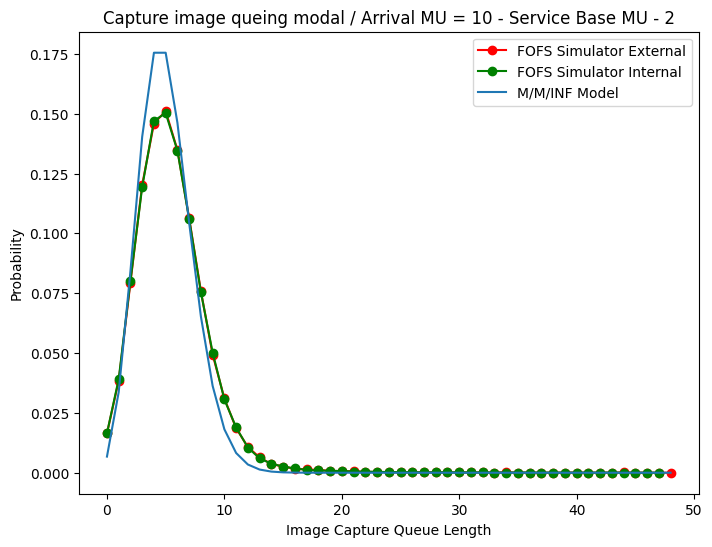

In [9]:
#####

# Modelo realizado para un MU de llegada de 10 req por dia y un MU de procesamiento de 2 req por día


#####



RANDOM_SEED = 420
REQ_ARRIVAL_MU = 10
PROC_BASE_MU = 2
N_REQUESTS = 100000

random.seed(RANDOM_SEED)

# Create an environment and start the setup process
env = simpy.Environment()
satellite = Satellite(env)

processing_times = []
external_sampling = []
env.process(get_values(env, satellite, external_sampling))

env.process(request_generator(env, satellite, processing_times))

# Execute!
env.run()


## External sampling mapping to x, y
y, x = rel_freq(external_sampling)

## Internal sampling mapping to x, y
y_internal, x_internal = rel_freq(satellite.get_internal_sample())

# poisson distribution data for y-axis
x_po = np.arange(0, len(x), 1)
y_po = poisson.pmf(x, mu=REQ_ARRIVAL_MU/PROC_BASE_MU)
 
 
# plotting the graph

plt.show()

fig, ax = plt.subplots(figsize=(8,6))
# ax.figure(figsize=(10,8))
ax.plot(x, y, 'r-o', label='FOFS Simulator External')
ax.plot(x_internal, y_internal, 'g-o', label='FOFS Simulator Internal')

ax.plot(x_po, y_po, label='M/M/INF Model')
ax.set_title('Capture image queing modal / Arrival MU = 10 - Service Base MU - 2')
ax.legend()
ax.set_xlabel('Image Capture Queue Length')
ax.set_ylabel('Probability')